In [1]:
%env THEANO_FLAGS='device=gpu1','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T
from lasagne import *

%matplotlib nbagg
import matplotlib.pyplot as plt

from mldm import NNWatcher, Net

env: THEANO_FLAGS='device=gpu1','floatX=float32'


Using gpu device 1: GeForce GTX 690 (CNMeM is disabled, cuDNN 5005)


In [2]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [3]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [4]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [5]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [6]:
def one_hot(y, n_classes=10):
    onehot = np.zeros(shape=(y.shape[0], n_classes), dtype='float32')

    onehot[np.arange(y.shape[0]), y] = 1.0
    return onehot

In [7]:
y = one_hot(y)
y_test = one_hot(y_test)

In [8]:
np.prod(X.shape[1:])

784

## Going deep

In [9]:
class DeepDenseMNISTNet(Net):
    def __init__(self):
        self.X_batch = T.ftensor4(name='X_batch')
        self.y_batch = T.fmatrix(name='y_batch')
        
        self.layers = []
        input_l = layers.InputLayer(shape=(None, ) + X.shape[1:], input_var=self.X_batch, name='Input')
        self.layers.append(input_l)
        
        reshape_l = layers.FlattenLayer(input_l)
        self.layers.append(reshape_l)

        for i, n_units in enumerate([500, 400, 300, 200, 100, 50, 20]):
            dense = layers.DenseLayer(
                self.layers[-1],
                num_units=n_units,
                nonlinearity=nonlinearities.sigmoid,
                name='Dense %d' % i
            )

            self.layers.append(dense)
        
        output_l = layers.DenseLayer(
            self.layers[-1],
            num_units=10,
            nonlinearity=nonlinearities.softmax,
            name= 'output'
        )
        
        self.layers.append(output_l)

        self.net = output_l
        
        self.predictions = layers.get_output(self.net)
        self.pure_loss = T.mean(objectives.categorical_crossentropy(self.predictions, self.y_batch))
        
        self.prior_params = [
            theano.shared(
                np.zeros(shape=param.get_value().shape, dtype='float32'),
                name = 'prior%d' % i
            )
            for i, param in enumerate(layers.get_all_params(self.net, regularizable=True))
        ]
        
        self.regularizations = [
            T.mean((param - prior) ** 2)
            for param, prior in
            zip(layers.get_all_params(self.net, regularizable=True), self.prior_params)
        ]
        
        self.regularization = reduce(lambda a, b: a + b, self.regularizations)
        self.regularization_coef = T.fscalar('regularization_coef')
        
        self.loss = self.pure_loss + self.regularization_coef * self.regularization
        
        self.learning_rate = T.fscalar('learning rate')
        params = layers.get_all_params(self.net)

        upd = updates.adadelta(self.loss, params, learning_rate=self.learning_rate)

        self.train = theano.function(
            [self.X_batch, self.y_batch, self.regularization_coef, self.learning_rate],
            self.pure_loss,
            updates=upd
        )

        self.get_loss = theano.function([self.X_batch, self.y_batch], self.pure_loss)
        
        super(DeepDenseMNISTNet, self).__init__()
    
    def copy_as_prior(self):
        for param, prior in zip(layers.get_all_params(self.net, regularizable=True), self.prior_params):
            value = param.get_value()
            prior.set_value(value)
            
    def save(self, path):
        params = layers.get_all_param_values(self.net)
        priors = [ prior.get_value() for prior in self.prior_params ]
        
        p = dict()
        for i, v in enumerate(params):
            p['param_%d' % i] = v

        for i, v in enumerate(priors):
            p['prior_%d' % i] = v

        return np.savez(path, **p)
    
    def load(self, path):
        with np.load(path) as f:
            params = layers.get_all_params(self.net)

            param_values = [ f['param_%d' % i] for i in xrange(len(params)) ]
            layers.set_all_param_values(self.net, param_values)
            
            for i, prior in enumerate(self.prior_params):
                prior.set_value(f['prior_%d' % i])

        return self
            
    @staticmethod
    def batch_stream(n, batch_size=32):
        n_batches = n / batch_size
        
        for i in xrange(n_batches):
            indx = np.random.choice(n, size=batch_size)
            yield indx
    
    def fit(self, X, y, n_epoches = 1, batch_size=32, regularization_coef=1.0e-3, learning_rate = 1.0):
        regularization_coef = np.float32(regularization_coef)
        learning_rate = np.float32(learning_rate)
        
        n_batches = X.shape[0] / batch_size
        losses = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
        
        for epoch in xrange(n_epoches):
            for i, indx in enumerate(self.batch_stream(X.shape[0], batch_size=batch_size)):
                losses[epoch, i] = self.train(X[indx], y[indx], regularization_coef, learning_rate)
            
            yield losses[:(epoch + 1)]

In [10]:
deep_net = DeepDenseMNISTNet()

In [11]:
deep_net.save('deep-net-0.npz')

<IPython.core.display.Javascript object>


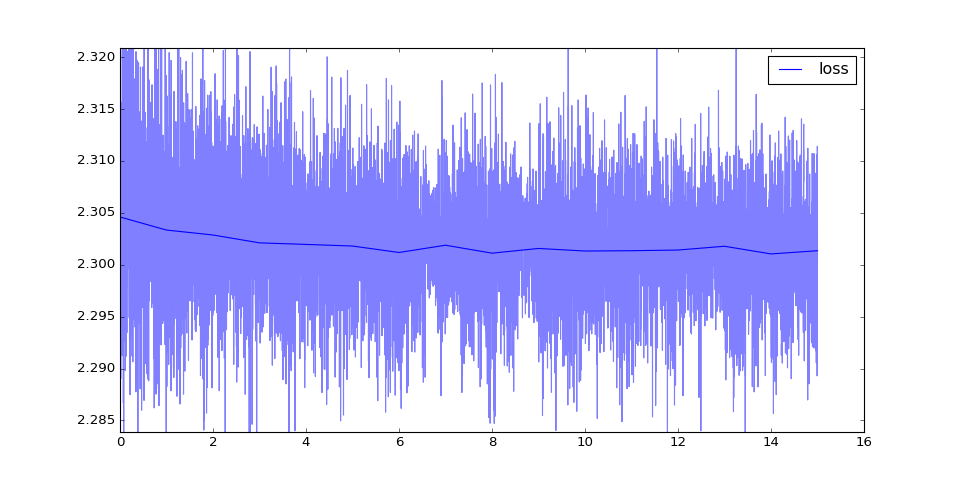

In [12]:
watcher = NNWatcher()

In [13]:
for loss in deep_net.fit(X, y, n_epoches=16, batch_size=128, regularization_coef=1.0e-3):
    watcher.draw(loss)

In [14]:
np.log(10)

2.3025850929940459

In [15]:
deep_net = deep_net.load('deep-net-0.npz')

In [16]:
class VAE(Net):
    def __init__(self, layer, X_input, p = 0.1):
        super(VAE, self).__init__()
        
        X_in = layers.get_output(layer.input_layer)
        in_shape = layer.input_shape
        out_shape = layer.output_shape
        
        self.in_layer = layers.InputLayer(shape=in_shape, input_var=X_in)

        self.dropout_l = layers.DropoutLayer(self.in_layer, p = p, rescale=False)
        
        self.encode_l = layers.DenseLayer(
            self.dropout_l,
            num_units=out_shape[1],
            W = layer.W,
            b = layer.b,
            nonlinearity = nonlinearities.sigmoid
        )
        
        self.decode_l = layers.DenseLayer(
            self.encode_l,
            num_units = in_shape[1],
            nonlinearity = nonlinearities.sigmoid
        )
        
        self.net = self.decode_l
        
        reconstructed = layers.get_output(self.decode_l)
        self.reconstructed = reconstructed
        
        self.loss = -T.mean(
            X_in * T.log(reconstructed) + (1 - X_in) * T.log(1 - reconstructed)
        )
        
        params = layers.get_all_params(self.net)
        
        learning_rate = T.fscalar('learning rate')
        upd = updates.adadelta(self.loss, params, learning_rate=learning_rate)
        
        self.train = theano.function([X_input, learning_rate], self.loss, updates=upd)
        

    @staticmethod
    def batch_stream(n, batch_size=32):
        n_batches = n / batch_size
        
        for i in xrange(n_batches):
            indx = np.random.choice(n, size=batch_size)
            yield indx
    
    def fit(self, X, n_epoches = 1, batch_size=32, learning_rate = 1.0):
        learning_rate = np.float32(learning_rate)
        
        n_batches = X.shape[0] / batch_size
        losses = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
        
        for epoch in xrange(n_epoches):
            for i, indx in enumerate(self.batch_stream(X.shape[0], batch_size=batch_size)):
                losses[epoch, i] = self.train(X[indx], learning_rate)
            
            yield losses[:(epoch + 1)]

<IPython.core.display.Javascript object>


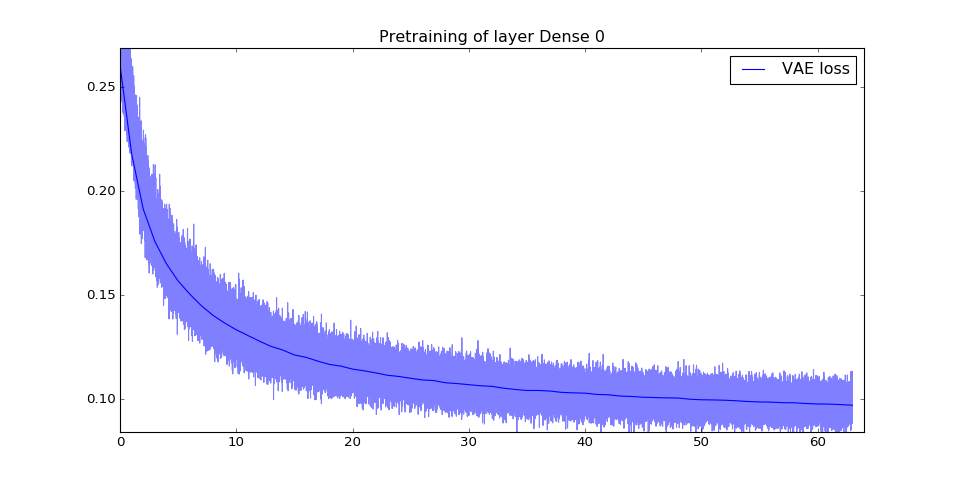

<IPython.core.display.Javascript object>


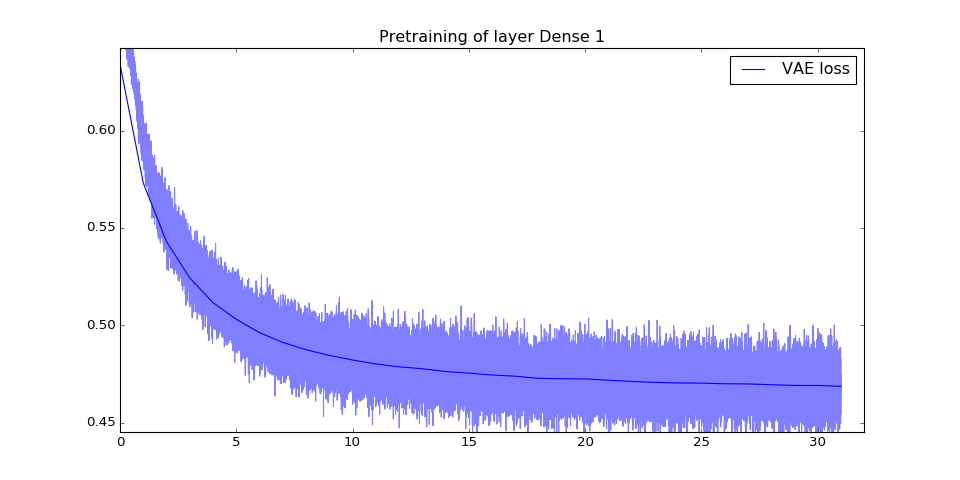

<IPython.core.display.Javascript object>


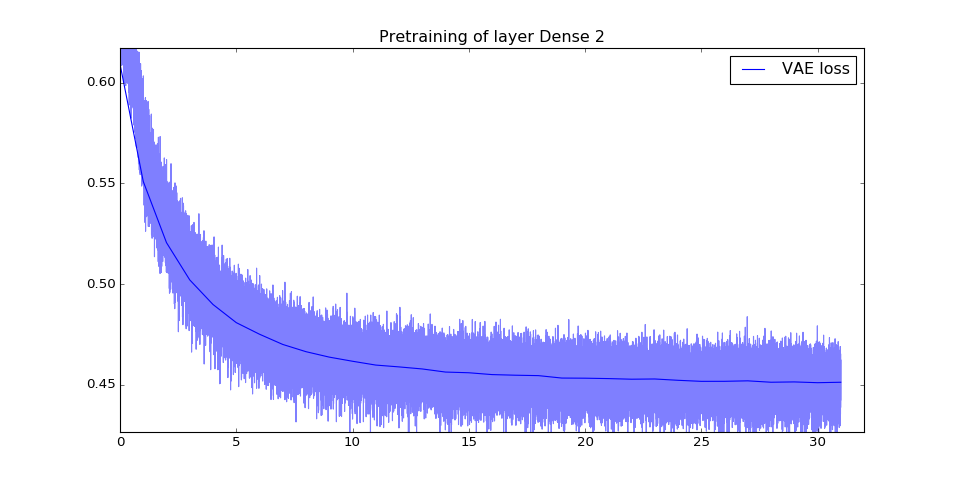

<IPython.core.display.Javascript object>


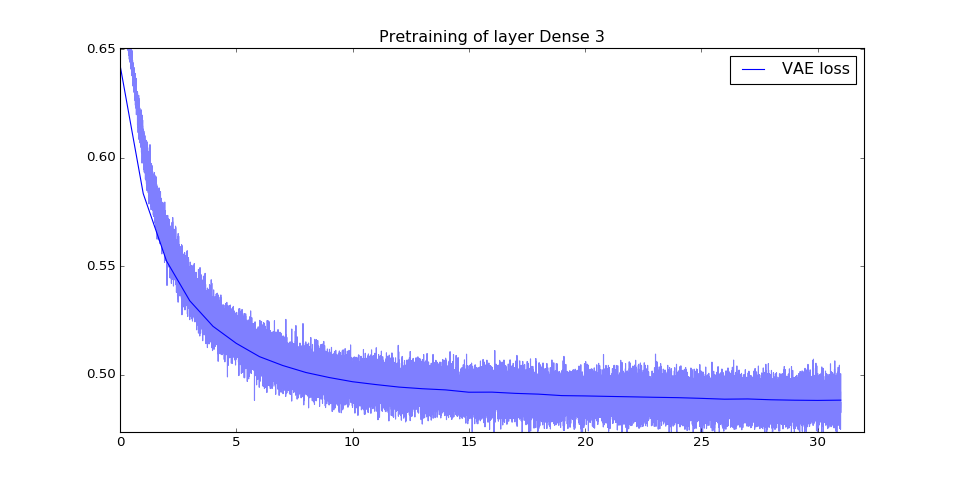

<IPython.core.display.Javascript object>


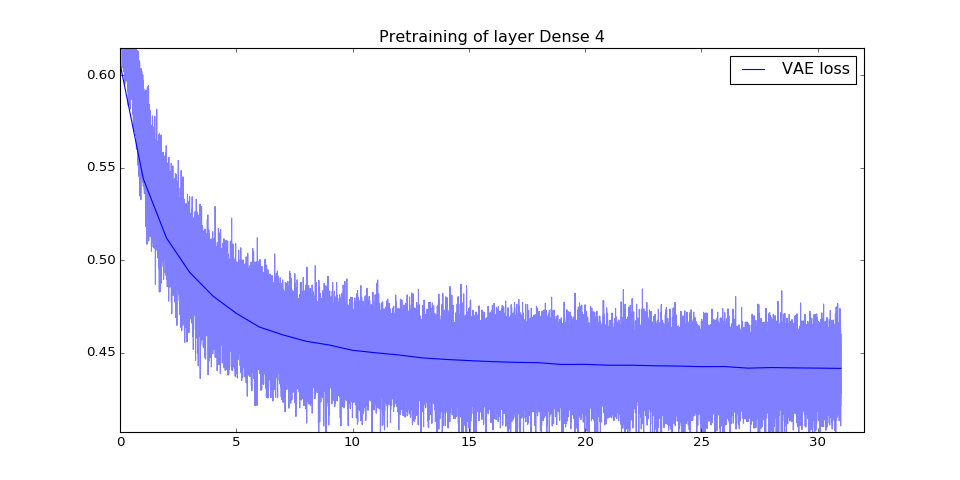

<IPython.core.display.Javascript object>


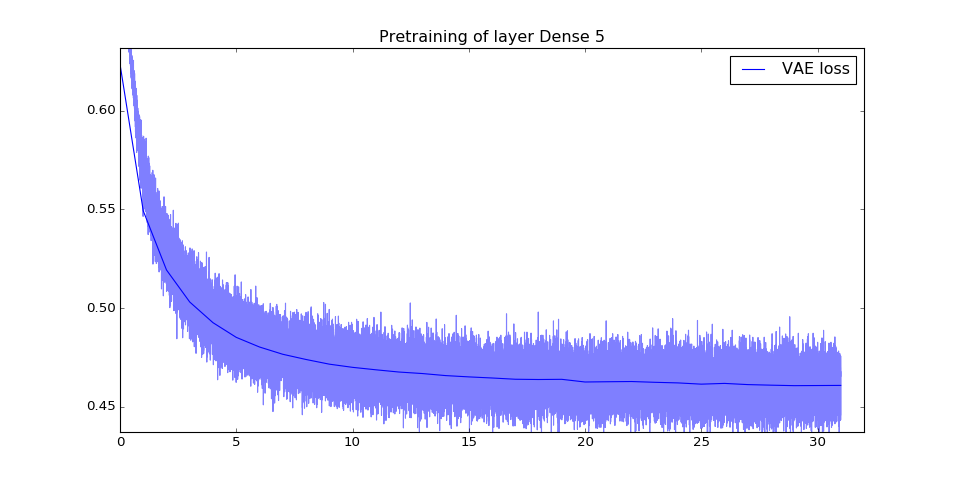

<IPython.core.display.Javascript object>


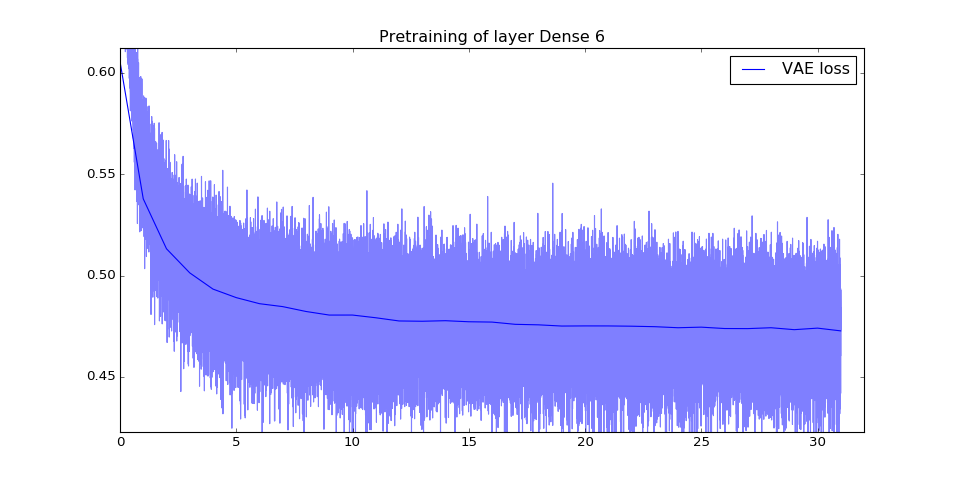

In [17]:
for i, l in enumerate(deep_net.layers[2:-1]):
    vae = VAE(l, p=0.25, X_input=deep_net.X_batch)
    watcher = NNWatcher(labels=['VAE loss'], colors=['blue'])
    watcher.ax.set_title("Pretraining of layer %s" % l.name)
    
    if i == 0:
        n_epoches = 64
    else:
        n_epoches = 32

    for l in vae.fit(X, n_epoches=n_epoches, batch_size=32, learning_rate=1.0):
        watcher.draw(l)
    
    deep_net.copy_as_prior()
    deep_net.save('deep-net-%d.npz' % (i + 1))
    
    plt.close(watcher.fig)

In [18]:
deep_net.load('deep-net-7.npz')

<IPython.core.display.Javascript object>


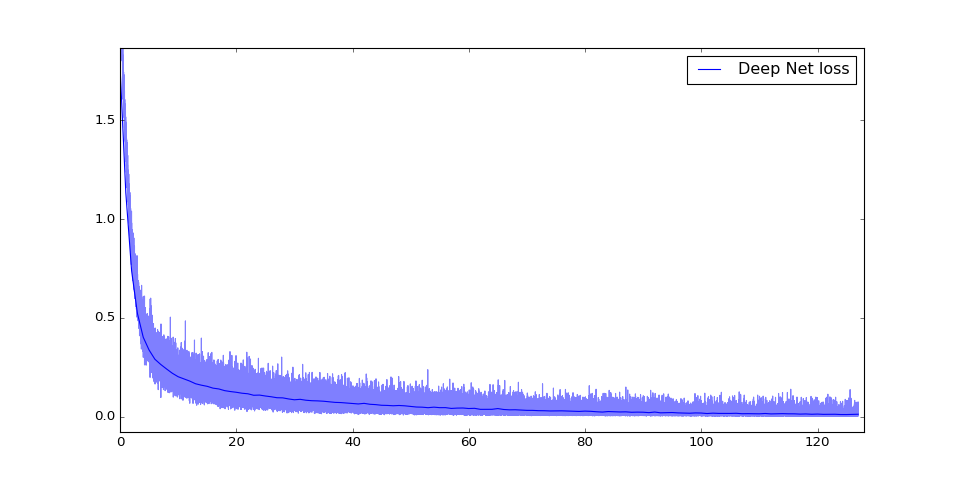

In [19]:
watcher = NNWatcher(labels=['Deep Net loss'], colors=['blue'])

In [20]:
for l in deep_net.fit(X, y, n_epoches=128, batch_size=128, learning_rate=1.0e-1, regularization_coef=1.0e-2):
    watcher.draw(l)

In [21]:
deep_net.save('deep-net-final.npz')

In [22]:
predict = theano.function([deep_net.X_batch], deep_net.predictions)

In [23]:
y_proba = predict(X_test)
print 'accuracy:', np.mean(np.argmax(y_test, axis=1) == np.argmax(y_proba, axis=1))

accuracy: 0.9819
